# Evaluation notebook for visualization purposes

In [31]:
from overall_evaluation import overall_evaluation
from LFWEvaluationDataset import LFWEvaluationDataset

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


In [32]:
# image_path = overall_evaluation()
# print(image_path)

# create here "overall_evaluation" method
# then wrap it into corresponding python skript
# then call it from main

### Test Dataset class

In [33]:
eval_dataset = LFWEvaluationDataset("./evaluation_data/lfw")

In [34]:
label, image_path = eval_dataset.__getitem__(4)

In [35]:
label

'Aaron_Peirsol'

In [36]:
image_path

'./evaluation_data/lfw\\Aaron_Peirsol\\Aaron_Peirsol_0002.jpg'

### Shuffle Dataset

In [37]:
# divide dataset size by twenty 10, so that processing is faster
subset_size = 10
n_samples = int(eval_dataset.__len__()/subset_size)
print("size of the whole dataset: ", eval_dataset.__len__())
print("size of the reduced dataset: ", n_samples)

# Shuffle indices with np.random.permutation, also fix seed if you want reproducability
shuffled_indices = np.random.RandomState(seed=42).permutation(n_samples)

# select shuffled set from original dataset
eval_dataset_shuffled = torch.utils.data.Subset(eval_dataset, indices=shuffled_indices)
len(eval_dataset)

size of the whole dataset:  13233
size of the reduced dataset:  1323


13233

In [38]:
label, image_path = eval_dataset.__getitem__(1)
label

'Aaron_Guiel'

### Create Dataloader

In [39]:
batch_size = 1
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset_shuffled,
                                           batch_size=batch_size,
                                           num_workers=0,
                                           shuffle=False, 
                                           sampler=None,
                                           collate_fn=None)

('Aaron_Eckhart',)
('Aaron_Guiel',)
('Aaron_Patterson',)
('Aaron_Peirsol',)
('Aaron_Peirsol',)
('Aaron_Peirsol',)
(250, 250, 3)


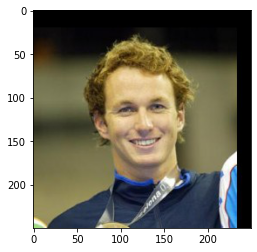

In [41]:
for i, (label, image_path) in enumerate(eval_loader):
    print(label)
    img_pil = Image.open(image_path[0])
    img_numpy = np.array(img_pil)
    plt.imshow(img_numpy)
    if i == 5:
        print(img_numpy.shape)
        break

**All tensor shapes for input are 1x3x250x250**

### For-loop: Feed each image through pipeline

In [42]:
# 2. Pass image through whole pipeline (detection & alignment # embedding)
# 3. Try to recognize person and then adapt TA, TR, ... (for first person, directly register --- for first people, use fixed threshold)
# 4. Register person to database
# print every 1000 images intermediate results

In [43]:
from deepface import DeepFace
from faceEmbeddingModel import faceEmbeddingModel
from reg_database import RegistrationDatabase

In [44]:
embedding_model = faceEmbeddingModel().eval()

# mode='euclidean_distance'
database = RegistrationDatabase()
database.clean_database()

Database already exists. Pickle file will be loaded...
database.pkl exists and will be cleaned...


In [45]:
for i, (label, image_path) in enumerate(eval_loader):
    label = label[0]
    # Face Detection and alignemnt
    detected_face_numpy = DeepFace.detectFace(image_path[0])
    
    # Reshape output
    detected_face = detected_face_numpy.copy()
    # Afterwards: Pytorch tensor 1x3x250x250
    detected_face = torch.from_numpy(detected_face).permute(2,0,1).unsqueeze(0)
    # print(detected_face.shape)
    #plt.imshow(detected_face.permute(1, 2, 0))
    
    # Face Embedding
    embedding = embedding_model(detected_face)
    
    # Face Recognition (No face recognition for first person, as no faces registered so far)
    if i > 0:
        closest_label, check = database.face_recognition(embedding)
    
    # Face Registration (if label not already in database -> If statement: true)
    if database.check_label_registered(label):
        database.face_registration(label,embedding)
        
    print(label)    
    if i == 10:
        break

Aaron_Eckhart
Aaron_Guiel
Aaron_Patterson
Aaron_Peirsol
Aaron_Peirsol
Aaron_Peirsol
Aaron_Peirsol
Aaron_Pena
Aaron_Sorkin
Aaron_Sorkin
Aaron_Tippin


In [46]:
database.database

,label,embedding,threshold
0,Aaron_Eckhart,"[[0.8157093, 0.24392603, 0.78041786, 0.5758638...",99.447495
1,Aaron_Guiel,"[[0.7439227, 0.19609766, 0.9252734, 0.7312888,...",99.447495
2,Aaron_Patterson,"[[0.8682445, 0.2823403, 0.9507681, 0.53932476,...",99.077415
3,Aaron_Peirsol,"[[0.84565926, 0.25903255, 0.8781705, 0.6236359...",99.301491
4,Aaron_Pena,"[[0.8977001, 0.18522575, 1.0335859, 0.6982815,...",99.077415
5,Aaron_Sorkin,"[[0.71255803, 0.21204071, 1.0136462, 0.859331,...",99.415894
6,Aaron_Tippin,"[[0.75946605, 0.009585236, 0.861542, 0.6451388...",99.056442
